In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MultiStateReporter2(MultiStateReporter):
    def read_energies(self, iteration=slice(None)):
        """Retrieve the energy matrix at the given iteration on the analysis file
        Parameters
        ----------
        iteration : int or slice
            The iteration(s) at which to read the data. The slice(None) allows fetching all iterations at once.
        Returns
        -------
        energy_thermodynamic_states : n_replicas x n_states numpy.ndarray
            ``energy_thermodynamic_states[iteration, i, j]`` is the reduced potential computed at
            SamplerState ``sampler_states[iteration, i]`` and ThermodynamicState ``thermodynamic_states[iteration, j]``.
        energy_neighborhoods : n_replicas x n_states numpy.ndarray
            energy_neighborhoods[replica_index, state_index] is 1 if the energy was computed for this state,
            0 otherwise
        energy_unsampled_states : n_replicas x n_unsampled_states numpy.ndarray
            ``energy_unsampled_states[iteration, i, j]`` is the reduced potential computed at SamplerState
            ``sampler_states[iteration, i]`` and ThermodynamicState ``unsampled_thermodynamic_states[iteration, j]``.
        """
        # Determine last consistent iteration
        iteration = self._map_iteration_to_good(iteration)
        # Retrieve energies at all thermodynamic states
        energy_thermodynamic_states = np.array(self._storage_analysis.variables['energies'][iteration, :, :], np.float64)
        # Retrieve neighborhoods, assuming global neighborhoods if reading a pre-neighborhoods file
        try:
            energy_neighborhoods = np.array(self._storage_analysis.variables['neighborhoods'][iteration, :, :], 'i1')
        except KeyError:
            energy_neighborhoods = np.ones(energy_thermodynamic_states.shape, 'i1')
        # Read energies at unsampled states, if present
#         try:
#             energy_unsampled_states = np.array(self._storage_analysis.variables['unsampled_energies'][iteration, :, :], np.float64)
#         except KeyError:
#             # There are no unsampled thermodynamic states.
        unsampled_shape = energy_thermodynamic_states.shape[:-1] + (0,)
        energy_unsampled_states = np.zeros(unsampled_shape)
        return energy_thermodynamic_states, energy_neighborhoods, energy_unsampled_states


In [3]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter2(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
    iterations_to_analyze = range(1, n_iterations, 100)
    print(list(iterations_to_analyze)) # check that this is giving me the last avail iteration
    for step in iterations_to_analyze: 
        analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
        f_ij, df_ij = analyzer.get_free_energy()
        dg.append(f_ij[0,-1])
        ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    print("Neff: ", analyzer.mbar.computeEffectiveSampleNumber())
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg), f_ij, df_ij

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/16)

In [4]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [5]:
main_dir = 32
sub_dir = 3
chunk = 16
titles = ['ALA->THR']

In [6]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical ineffic

DEBUG:openmmtools.multistate.multistateanalyzer:   0.207   0.207   0.131   0.070   0.000   0.081   0.169   0.250   0.316   0.364   0.399   0.434   0.473   0.517   0.561   0.602   0.640   0.678   0.719   0.769   0.828   0.896   0.963   1.024
DEBUG:openmmtools.multistate.multistateanalyzer:   0.280   0.280   0.209   0.150   0.081   0.000   0.088   0.173   0.242   0.293   0.332   0.370   0.415   0.463   0.512   0.556   0.597   0.637   0.680   0.733   0.795   0.865   0.935   0.998
DEBUG:openmmtools.multistate.multistateanalyzer:   0.356   0.356   0.290   0.235   0.169   0.088   0.000   0.086   0.158   0.212   0.256   0.300   0.351   0.406   0.459   0.508   0.551   0.594   0.640   0.695   0.761   0.834   0.906   0.971
DEBUG:openmmtools.multistate.multistateanalyzer:   0.425   0.425   0.366   0.314   0.250   0.173   0.086   0.000   0.073   0.131   0.180   0.233   0.291   0.352   0.410   0.462   0.508   0.554   0.603   0.661   0.730   0.805   0.880   0.946
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:  -3.145  -3.145  -2.744  -1.758  -0.929  -0.330   0.000   0.035  -0.246  -0.858  -1.807  -3.099  -4.748  -6.776  -9.204 -12.051 -15.323 -19.027 -23.166 -27.744 -32.762 -38.214 -44.085 -50.340
DEBUG:openmmtools.multistate.multistateanalyzer:  -3.179  -3.179  -2.779  -1.793  -0.964  -0.365  -0.035   0.000  -0.281  -0.893  -1.842  -3.134  -4.783  -6.810  -9.239 -12.085 -15.358 -19.062 -23.200 -27.779 -32.797 -38.249 -44.120 -50.374
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.898  -2.898  -2.498  -1.512  -0.683  -0.084   0.246   0.281   0.000  -0.612  -1.561  -2.853  -4.502  -6.529  -8.958 -11.804 -15.077 -18.780 -22.919 -27.498 -32.516 -37.968 -43.839 -50.093
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.287  -2.287  -1.886  -0.900  -0.071   0.528   0.858   0.893   0.612   0.000  -0.949  -2.241  -3.890  -5.918  -8.346 -11.192 -14.465 -18.169 -22.308 -26.886 -31.904 -37.356 -43.227 -49.482
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:   0.187   0.187   0.179   0.173   0.166   0.159   0.151   0.141   0.131   0.120   0.108   0.094   0.078   0.059   0.040   0.020   0.000   0.019   0.036   0.052   0.067   0.081   0.095   0.108
DEBUG:openmmtools.multistate.multistateanalyzer:   0.194   0.194   0.186   0.180   0.174   0.167   0.159   0.150   0.141   0.131   0.119   0.107   0.092   0.075   0.057   0.038   0.019   0.000   0.018   0.035   0.051   0.067   0.082   0.097
DEBUG:openmmtools.multistate.multistateanalyzer:   0.200   0.200   0.192   0.187   0.181   0.174   0.167   0.158   0.149   0.140   0.129   0.117   0.104   0.088   0.072   0.054   0.036   0.018   0.000   0.018   0.035   0.052   0.068   0.084
DEBUG:openmmtools.multistate.multistateanalyzer:   0.206   0.206   0.198   0.193   0.187   0.181   0.173   0.165   0.157   0.148   0.138   0.127   0.114   0.100   0.085   0.069   0.052   0.035   0.018   0.000   0.018   0.036   0.053   0.071
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:  19.609  19.609  19.981  20.943  21.747  22.321  22.631  22.651  22.365  21.764  20.841  19.583  17.976  16.002  13.644  10.883   7.699   4.075   0.000  -4.528  -9.506 -14.927 -20.773 -27.010
DEBUG:openmmtools.multistate.multistateanalyzer:  24.137  24.137  24.509  25.471  26.274  26.849  27.159  27.179  26.893  26.292  25.369  24.111  22.504  20.530  18.172  15.411  12.227   8.603   4.528   0.000  -4.978 -10.399 -16.245 -22.482
DEBUG:openmmtools.multistate.multistateanalyzer:  29.115  29.115  29.487  30.449  31.253  31.827  32.137  32.157  31.872  31.271  30.347  29.089  27.482  25.508  23.150  20.390  17.206  13.581   9.506   4.978   0.000  -5.421 -11.267 -17.503
DEBUG:openmmtools.multistate.multistateanalyzer:  34.536  34.536  34.908  35.870  36.673  37.248  37.558  37.578  37.292  36.691  35.768  34.510  32.903  30.929  28.571  25.810  22.626  19.002  14.927  10.399   5.421   0.000  -5.846 -12.083
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 4
DEBUG:openmmtools.multistate.multistateanalyzer: statistical inefficiency of production region   : 2.3284995555877686
DEBUG:openmmtools.multistate.multistateanalyzer: effective number of uncorrelated samples        : 128.40887451171875
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covar

DEBUG:openmmtools.multistate.multistateanalyzer:   0.057   0.057   0.044   0.035   0.024   0.013   0.000   0.014   0.027   0.038   0.049   0.058   0.066   0.074   0.081   0.088   0.094   0.100   0.105   0.110   0.115   0.119   0.123   0.128
DEBUG:openmmtools.multistate.multistateanalyzer:   0.066   0.066   0.054   0.046   0.037   0.026   0.014   0.000   0.014   0.026   0.038   0.048   0.058   0.066   0.074   0.082   0.088   0.094   0.100   0.105   0.110   0.114   0.119   0.123
DEBUG:openmmtools.multistate.multistateanalyzer:   0.073   0.073   0.063   0.056   0.048   0.038   0.027   0.014   0.000   0.013   0.026   0.037   0.048   0.058   0.067   0.075   0.082   0.088   0.094   0.100   0.105   0.109   0.114   0.119
DEBUG:openmmtools.multistate.multistateanalyzer:   0.080   0.080   0.071   0.064   0.057   0.049   0.038   0.026   0.013   0.000   0.013   0.026   0.038   0.049   0.058   0.067   0.075   0.082   0.088   0.094   0.099   0.104   0.109   0.114
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:  -2.706  -2.706  -2.336  -1.380  -0.587  -0.025   0.277   0.292   0.000  -0.610  -1.546  -2.817  -4.434  -6.414  -8.773 -11.530 -14.704 -18.313 -22.369 -26.876 -31.832 -37.226 -43.037 -49.231
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.096  -2.096  -1.726  -0.770   0.023   0.586   0.887   0.902   0.610   0.000  -0.936  -2.207  -3.824  -5.804  -8.163 -10.919 -14.094 -17.702 -21.758 -26.266 -31.222 -36.615 -42.427 -48.621
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.160  -1.160  -0.790   0.166   0.959   1.522   1.823   1.838   1.546   0.936   0.000  -1.271  -2.888  -4.868  -7.227  -9.983 -13.157 -16.766 -20.822 -25.330 -30.286 -35.679 -41.491 -47.685
DEBUG:openmmtools.multistate.multistateanalyzer:   0.111   0.111   0.481   1.437   2.230   2.792   3.094   3.109   2.817   2.207   1.271   0.000  -1.618  -3.597  -5.956  -8.713 -11.887 -15.496 -19.552 -24.059 -29.015 -34.409 -40.220 -46.414
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:   0.123   0.123   0.118   0.115   0.111   0.107   0.102   0.097   0.092   0.086   0.079   0.072   0.065   0.056   0.046   0.036   0.024   0.012   0.000   0.012   0.023   0.033   0.042   0.052
DEBUG:openmmtools.multistate.multistateanalyzer:   0.127   0.127   0.122   0.119   0.116   0.112   0.107   0.102   0.097   0.092   0.086   0.079   0.072   0.064   0.055   0.046   0.035   0.023   0.012   0.000   0.011   0.022   0.032   0.043
DEBUG:openmmtools.multistate.multistateanalyzer:   0.131   0.131   0.126   0.123   0.120   0.116   0.112   0.107   0.102   0.097   0.091   0.085   0.078   0.071   0.063   0.054   0.045   0.034   0.023   0.011   0.000   0.011   0.022   0.033
DEBUG:openmmtools.multistate.multistateanalyzer:   0.135   0.135   0.130   0.127   0.124   0.120   0.116   0.111   0.107   0.102   0.096   0.090   0.084   0.078   0.070   0.062   0.053   0.043   0.033   0.022   0.011   0.000   0.011   0.023
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:  28.931  28.931  29.298  30.244  31.026  31.572  31.854  31.853  31.556  30.952  30.027  28.767  27.157  25.185  22.838  20.104  16.964  13.398   9.387   4.921   0.000  -5.365 -11.154 -17.333
DEBUG:openmmtools.multistate.multistateanalyzer:  34.296  34.296  34.663  35.609  36.391  36.937  37.219  37.218  36.921  36.317  35.392  34.132  32.522  30.550  28.203  25.469  22.329  18.763  14.752  10.286   5.365   0.000  -5.789 -11.968
DEBUG:openmmtools.multistate.multistateanalyzer:  40.086  40.086  40.452  41.399  42.180  42.727  43.009  43.008  42.710  42.106  41.182  39.922  38.312  36.339  33.992  31.258  28.119  24.552  20.541  16.075  11.154   5.789   0.000  -6.178
DEBUG:openmmtools.multistate.multistateanalyzer:  46.264  46.264  46.630  47.577  48.358  48.905  49.187  49.186  48.889  48.284  47.360  46.100  44.490  42.517  40.171  37.437  34.297  30.730  26.719  22.253  17.333  11.968   6.178   0.000
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer: effective number of uncorrelated samples        : 195.2224884033203
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling uncorrelated energies...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing free energy differences...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Computing covariance matrix...
DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.365   1.310   2.090   2.633   2.911   2.905   2.603   1.994   1.067  -0.192  -1.794  -3.752  -6.083  -8.805 -11.937 -15.500 -19.510 -23.973 -28.889 -34.250 -40.035 -46.211
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.365   1.310   2.090   2.633   2.911   2.905   2.603   1.994   1.067  -0.192  -1.794  -3.752  -6.083  -8.805 -11.937 -15.500 -19.510 -23.973 -28.889 -34.250 -4

DEBUG:openmmtools.multistate.multistateanalyzer:   0.058   0.058   0.049   0.043   0.037   0.029   0.020   0.010   0.000   0.010   0.021   0.030   0.038   0.046   0.053   0.059   0.065   0.070   0.075   0.079   0.083   0.087   0.091   0.095
DEBUG:openmmtools.multistate.multistateanalyzer:   0.063   0.063   0.055   0.050   0.044   0.037   0.029   0.020   0.010   0.000   0.011   0.021   0.030   0.039   0.046   0.053   0.059   0.065   0.070   0.075   0.079   0.083   0.087   0.091
DEBUG:openmmtools.multistate.multistateanalyzer:   0.068   0.068   0.061   0.056   0.051   0.045   0.038   0.030   0.021   0.011   0.000   0.011   0.021   0.030   0.038   0.046   0.053   0.059   0.065   0.070   0.074   0.079   0.083   0.087
DEBUG:openmmtools.multistate.multistateanalyzer:   0.073   0.073   0.066   0.062   0.057   0.052   0.045   0.038   0.030   0.021   0.011   0.000   0.010   0.020   0.030   0.038   0.046   0.053   0.059   0.065   0.069   0.074   0.078   0.083
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:  -1.065  -1.065  -0.713   0.226   1.002   1.544   1.823   1.821   1.525   0.922   0.000  -1.252  -2.845  -4.792  -7.111  -9.821 -12.946 -16.504 -20.508 -24.962 -29.868 -35.218 -40.995 -47.165
DEBUG:openmmtools.multistate.multistateanalyzer:   0.187   0.187   0.539   1.478   2.254   2.796   3.075   3.073   2.777   2.174   1.252   0.000  -1.593  -3.540  -5.859  -8.569 -11.694 -15.252 -19.256 -23.710 -28.616 -33.966 -39.743 -45.913
DEBUG:openmmtools.multistate.multistateanalyzer:   1.781   1.781   2.132   3.071   3.847   4.389   4.668   4.666   4.370   3.767   2.845   1.593   0.000  -1.947  -4.265  -6.976 -10.101 -13.659 -17.663 -22.117 -27.023 -32.373 -38.150 -44.319
DEBUG:openmmtools.multistate.multistateanalyzer:   3.728   3.728   4.079   5.018   5.794   6.336   6.615   6.614   6.318   5.714   4.792   3.540   1.947   0.000  -2.318  -5.029  -8.154 -11.712 -15.715 -20.170 -25.076 -30.426 -36.203 -42.372
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:   0.100   0.100   0.096   0.093   0.091   0.088   0.085   0.081   0.077   0.073   0.069   0.065   0.060   0.054   0.048   0.041   0.034   0.026   0.017   0.009   0.000   0.009   0.017   0.026
DEBUG:openmmtools.multistate.multistateanalyzer:   0.102   0.102   0.099   0.096   0.093   0.091   0.088   0.084   0.081   0.077   0.073   0.069   0.064   0.059   0.054   0.047   0.040   0.033   0.025   0.017   0.009   0.000   0.009   0.018
DEBUG:openmmtools.multistate.multistateanalyzer:   0.105   0.105   0.101   0.099   0.096   0.094   0.091   0.088   0.084   0.081   0.077   0.073   0.068   0.064   0.059   0.053   0.047   0.040   0.033   0.025   0.017   0.009   0.000   0.009
DEBUG:openmmtools.multistate.multistateanalyzer:   0.108   0.108   0.104   0.102   0.099   0.097   0.094   0.091   0.088   0.084   0.081   0.077   0.073   0.068   0.063   0.058   0.053   0.047   0.040   0.033   0.026   0.018   0.009   0.000
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:  39.760  39.760  40.105  41.047  41.835  42.395  42.691  42.700  42.412  41.816  40.902  39.660  38.079  36.144  33.838  31.141  28.031  24.488  20.498  16.050  11.143   5.787   0.000  -6.180
DEBUG:openmmtools.multistate.multistateanalyzer:  45.940  45.940  46.285  47.227  48.015  48.575  48.871  48.881  48.592  47.996  47.082  45.840  44.259  42.324  40.019  37.321  34.211  30.669  26.678  22.230  17.323  11.967   6.180   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.013   0.021   0.027   0.034   0.040   0.045   0.050   0.055   0.059   0.064   0.067   0.071   0.075   0.078   0.082   0.085   0.088   0.091   0.094   0.097   0.099   0.102
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.013   0.021   0.027   0.034   0.040   0.045   0.050   0.055   0.059   0.064   0.067   0.071   0.075   0.078   0.082   0.085   0.088   0.091   0.094 

DEBUG:openmmtools.multistate.multistateanalyzer:Deltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.342   1.272   2.040   2.578   2.857   2.859   2.570   1.977   1.067  -0.175  -1.761  -3.704  -6.020  -8.726 -11.843 -15.390 -19.381 -23.826 -28.727 -34.077 -39.856 -46.029
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.342   1.272   2.040   2.578   2.857   2.859   2.570   1.977   1.067  -0.175  -1.761  -3.704  -6.020  -8.726 -11.843 -15.390 -19.381 -23.826 -28.727 -34.077 -39.856 -46.029
DEBUG:openmmtools.multistate.multistateanalyzer:  -0.342  -0.342   0.000   0.929   1.698   2.236   2.515   2.517   2.228   1.635   0.724  -0.517  -2.103  -4.046  -6.362  -9.069 -12.186 -15.732 -19.723 -24.168 -29.069 -34.419 -40.199 -46.371
DEBUG:openmmtools.multistate.multistateanalyzer:  -1.272  -1.272  -0.929   0.000   0.768   1.306   1.586   1.588   1.298   0.705  -0.205  -1.447  -3.033  -4.976  -7.292  -9.998 -13.115 -16.662 -20.653 -25.098 -29.999 -

DEBUG:openmmtools.multistate.multistateanalyzer:   0.056   0.056   0.050   0.046   0.042   0.037   0.031   0.025   0.017   0.009   0.000   0.009   0.017   0.025   0.032   0.038   0.044   0.049   0.053   0.057   0.061   0.065   0.068   0.072
DEBUG:openmmtools.multistate.multistateanalyzer:   0.060   0.060   0.054   0.051   0.047   0.043   0.038   0.032   0.025   0.017   0.009   0.000   0.009   0.017   0.025   0.031   0.038   0.043   0.048   0.053   0.057   0.061   0.064   0.068
DEBUG:openmmtools.multistate.multistateanalyzer:   0.064   0.064   0.059   0.055   0.052   0.048   0.043   0.038   0.032   0.025   0.017   0.009   0.000   0.009   0.017   0.024   0.031   0.038   0.043   0.048   0.053   0.057   0.061   0.064
DEBUG:openmmtools.multistate.multistateanalyzer:   0.067   0.067   0.063   0.060   0.056   0.053   0.049   0.044   0.038   0.032   0.025   0.017   0.009   0.000   0.008   0.017   0.024   0.031   0.037   0.043   0.048   0.052   0.056   0.060
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:   1.668   1.668   2.005   2.944   3.729   4.289   4.589   4.609   4.332   3.744   2.832   1.588   0.000  -1.944  -4.260  -6.966 -10.081 -13.624 -17.610 -22.051 -26.949 -32.297 -38.074 -44.242
DEBUG:openmmtools.multistate.multistateanalyzer:   3.611   3.611   3.949   4.888   5.673   6.233   6.533   6.553   6.276   5.688   4.776   3.532   1.944   0.000  -2.316  -5.022  -8.137 -11.680 -15.666 -20.107 -25.006 -30.353 -36.130 -42.298
DEBUG:openmmtools.multistate.multistateanalyzer:   5.928   5.928   6.265   7.204   7.989   8.549   8.850   8.869   8.592   8.004   7.092   5.848   4.260   2.316   0.000  -2.706  -5.821  -9.364 -13.350 -17.791 -22.689 -28.037 -33.814 -39.982
DEBUG:openmmtools.multistate.multistateanalyzer:   8.634   8.634   8.971   9.910  10.696  11.255  11.556  11.575  11.298  10.710   9.798   8.554   6.966   5.022   2.706   0.000  -3.115  -6.657 -10.644 -15.085 -19.983 -25.331 -31.107 -37.276
DEBUG:openmmtools.multistate.multist

DEBUG:openmmtools.multistate.multistateanalyzer:   0.089   0.089   0.086   0.084   0.082   0.080   0.077   0.074   0.071   0.068   0.065   0.061   0.058   0.054   0.049   0.045   0.040   0.034   0.028   0.022   0.015   0.007   0.000   0.008
DEBUG:openmmtools.multistate.multistateanalyzer:   0.091   0.091   0.089   0.087   0.085   0.082   0.080   0.077   0.074   0.071   0.068   0.065   0.061   0.057   0.053   0.049   0.045   0.040   0.034   0.028   0.022   0.015   0.008   0.000


Neff:  [1578.42811079 1578.42811079 2178.03158541 2481.43374152 2693.22732992
 2817.91456108 2871.78949958 2897.18728391 2899.92971256 2883.41112834
 2874.7925861  2888.81779023 2912.66145931 2930.50201877 2944.01844305
 2959.99867443 2979.34456008 2982.58087776 2932.26909338 2790.20729546
 2532.93894014 2172.36408983 1760.08860726 1357.88664386]


In [7]:
apo_dg

array([-48.97751743, -47.19508986, -46.61844929, -46.4944471 ,
       -46.5250292 , -46.26372055, -46.21100248, -46.09992195,
       -45.9398087 , -46.02875074, -45.90982084])

In [8]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


16 apo: -45.90982084424695 (0.09139647610860835) kT



In [9]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so ti

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMo

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so ti

<Figure size 1080x3456 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/17)

In [10]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [11]:
main_dir = 32
sub_dir = 3
chunk = 17
titles = ['ALA->THR']

In [12]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [1332.58506149 1332.58506149 1860.29975765 2110.24477729 2223.50201134
 2276.73094829 2285.56009894 2283.24538899 2317.7272347  2393.82205481
 2463.37657309 2373.85241362 1922.83700301 1926.58893864 2374.22410782
 2492.93366507 2444.14245299 2339.46360861 2225.1338803  2109.8465282
 1967.71361564 1738.3422814  1371.1169546   911.78733696]


In [13]:
apo_dg

array([-50.01015201, -47.88947379, -48.06307407, -48.22916013,
       -48.252894  , -48.28350024, -48.15706278, -48.0394507 ,
       -48.07621428, -47.95734498, -47.94768145])

In [14]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


17 apo: -47.94768145263614 (0.1139348060120001) kT



In [15]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x3456 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/18)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [17]:
main_dir = 32
sub_dir = 3
chunk = 18
titles = ['ALA->THR']

In [18]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [1124.45860198 1124.45860198 1547.28611684 1681.63423197 1665.95775325
 1606.21014872 1540.72575968 1529.27993157 1572.00965937 1660.79576605
 1826.30142237 1815.63262421 1218.26479132 1219.78891184 1767.34510025
 1822.74601265 1660.67342353 1530.9177741  1479.36837605 1444.38335741
 1411.98156425 1332.59922051 1105.20816988  679.24976714]


In [19]:
apo_dg

array([-53.7244023 , -49.9268434 , -49.48370251, -49.74509244,
       -50.21505911, -49.98870157, -49.60889871, -49.34655047,
       -49.41759809, -49.36161156, -49.70714827])

In [20]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


18 apo: -49.70714827432663 (0.15227341649360066) kT



In [21]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x3456 with 0 Axes>

# Plot

In [22]:
d_results = {}

for chunk in [16, 17, 18]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[chunk] = results

In [25]:
def plot_series(d_results, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    labels = ['No REST', 'T_max = 600 K', 'T_max = 1200 K']
    for i, r in enumerate(list(d_results.keys())):
        dg_discarded = d_results[r][0]
        ddg_discarded = d_results[r][1]

        # dg
        ax = axes[0]
        x = np.array(range(len(dg_discarded)))/10 # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        y = dg_discarded
        ax.plot(x, y, label=f'{labels[i]}')
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
        x = np.array(range(len(ddg_discarded)))/10
        y = ddg_discarded
        ax.plot(x, y)

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    axes[0].legend()
    axes[0].axhline(y=-46)
    axes[0].axhline(y=-50)
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/{chunk}_{phase}_series.png", dpi=500)
#     plt.clf()

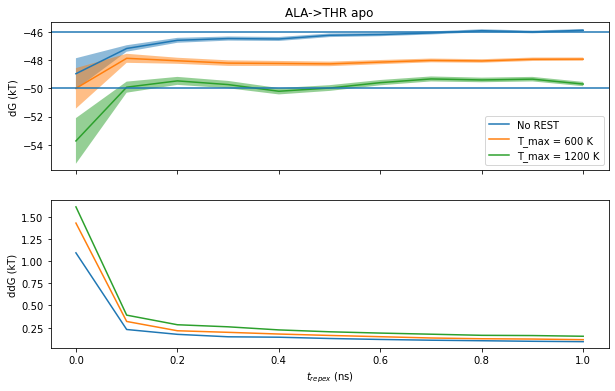

In [26]:
plot_series(d_results, 'apo', 'ALA->THR')